In [1]:
import numpy as np
import nengo
import nengolib
from nengolib.signal import s

import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

## Aaron's original method 

This is the basic "soft-mux" or "gradual training" or "graded supervision" method. Here, the supervision comes through the node "presyn" as a vector, while the ensemble "x" has default neuron_type=AdaptiveLIFRate().

In [2]:
def go(transition=[0, 1],
       ensemble_seed=0,
       n=50,
       neuron_type=nengo.AdaptiveLIFRate(tau_n=0.1, inc_n=0.01),
       tau=0.1,
       solver=nengo.solvers.LstsqL2(reg=0.5),
       freq=5,
       t=1,
       cmap="winter",
       verbose=False):

    d = np.zeros((n, 1))
    scatter_y = []
    scatter_x = []
    scatter_c = []
    scatter_e = []
    scatter_i = range(1, len(transition))
    
    A = 2*np.pi*freq
    syn_train=nengo.Lowpass(tau)

    for g, p in enumerate(transition):
        with nengo.Network() as model:
            stim = nengo.Node(output=lambda t: A*np.cos(A*t))
            presyn = nengo.Node(size_in=1)  # tau*dot{x} + x == tau*u + int{u}
            x = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=ensemble_seed)
            
            nengo.Connection(stim, presyn, synapse=None, transform=tau)
            nengo.Connection(x, presyn, synapse=None, transform=p,
                             solver=nengo.solvers.NoSolver(d))
            nengo.Connection(stim, presyn, synapse=1/s, transform=1-p)
            nengo.Connection(presyn, x, synapse=tau)
            
            p_a = nengo.Probe(x.neurons, synapse=None)
            p_x = nengo.Probe(presyn, synapse=tau)
            p_y = nengo.Probe(stim, synapse=1/s)
            
        with nengo.Simulator(model, progress_bar=False) as sim:
            sim.run(t, progress_bar=False)

        new_d, _ = solver(syn_train.filt(sim.data[p_a]),
                          syn_train.filt(sim.data[p_y]))
        e = nengolib.signal.nrmse(sim.data[p_x], target=sim.data[p_y])
        
        if g > 0:
            scatter_x.extend(np.arange(n) + g / float(len(transition)))
            scatter_y.extend(new_d - d)
            scatter_c.extend([g]*n)
            scatter_e.append(e)
        d = new_d
        
        if verbose:
            plt.figure()
            plt.title(r"p=%s $\Longrightarrow$ NRMSE=%.3f" % (p, e))
            plt.plot(sim.trange(), sim.data[p_y], label=r"$x$", linestyle='--')
            plt.plot(sim.trange(), sim.data[p_x], label=r"$\hat{x}$")
            plt.legend()
            plt.show()
    
    def ax_ylim(ax, pts, padding=0.1):
        u = max(pts)
        l = min(pts)
        r = u - l
        if r > 0:
            ax.set_ylim(l - r*padding, u + r*padding)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].set_title("Decoder Transition")
    ax[0].scatter(scatter_x, scatter_y, c=scatter_c, cmap=cmap)
    ax[0].set_xlabel("Neuron Index")
    ax[0].set_ylabel(r"$\Delta \mathbf{d}$")
    ax_ylim(ax[0], scatter_y)
    ax[1].set_title("Integration Error")
    ax[1].scatter(scatter_i, scatter_e, c=scatter_i, cmap=cmap)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("NRMSE")    
    ax_ylim(ax[1], scatter_e)
    fig.show()

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


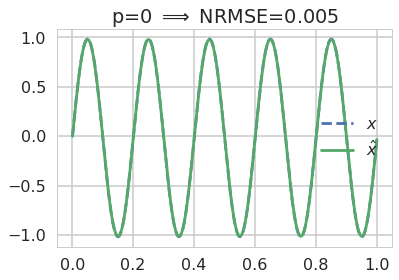

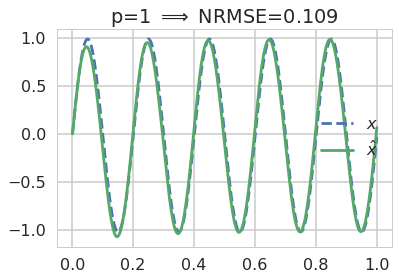

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


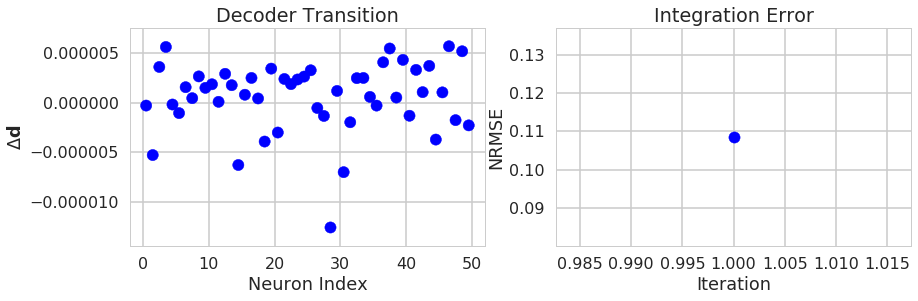

In [3]:
go(verbose=True)

Run this training regime on AdaptiveLIFRate() neurons with moderate regularization, $reg=0.5$.

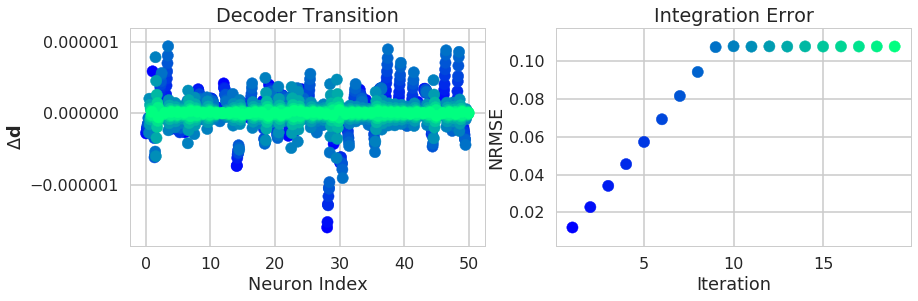

In [4]:
go(np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))))

Observation: the error grows steadily as the switch from supervision to non-supervision is applied. Continuing to apply the decoder update procedure once supervision is removed (all spikes are coming through the recurrent connection) does not cause the decoders to diverge, indicating the computed decoders are "stable" in some sense. The final error is moderate ($NRMSE=0.12$).

Try the same training, but with a smaller regularization ($reg=0.1$) on the solver used to compute the recurrent decoders.

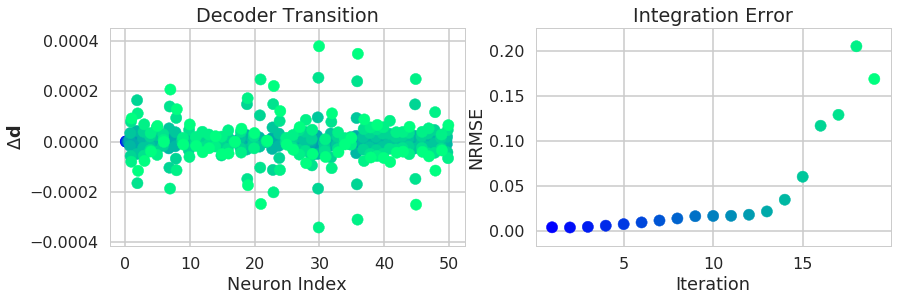

In [5]:
go(np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))),
   solver=nengo.solvers.LstsqL2(reg=0.1))

Observation: though the $nrmse$ throughout the transition is lower than the first simulation, repeatedly running the training procedure on a network utilizing  this solver causes oscillating $\Delta \mathbf{d}$ and growing error.

Tentative conclusion: lower regularization can produce networks that more accurately decode the signal, but the recurrent weight matrix is more susceptible to perturbation/noise if the training is not turned off at the right time.

## New method uses a network has fully spiking recurrence and training
And hence supports neuron_type=BahlNeuron() substituion. Also features a few more details on connections going in/out of "bio" to support BahlNeuron() connections.

In [6]:
from nengo_bioneurons import BahlNeuron, build_filter

def go2(transition=[0, 1],
       es=0,
       cs=1,
       n=100,
       neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
       tau=0.1,
       inter_solvers=[nengo.solvers.LstsqL2(reg=0.1)],
       solvers=[nengo.solvers.LstsqL2(reg=1.0)],
       freq=5,
       t=1,
       cmap="winter",
       verbose=False,
       n_pre2=100,
       tau_pre2=0.01,
       n_syns=[1],
       h_out=nengo.Lowpass(0.1),
       secs=['apical']):

    scatter_y = []
    scatter_x = []
    scatter_c = []
    scatter_e = []
    scatter_i = range(1, len(transition))
 
    # first find the norm of the filtered signal
    lpf=nengo.Lowpass(tau)
    lpf2=nengo.Lowpass(tau_pre2)
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = h_out.filt(sim.data[p_integral])
    target_f2f = h_out.filt(lpf2.filt(sim.data[p_integral]))
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    norm_f2f = np.max(np.abs(target_f2f))
    
    # now solve for "inter" decoders, which will be used to compute
    # weights on the inter_bio connection
    with nengo.Network() as model:
        stim = nengo.Node(output=lambda t: np.cos(freq*t))
        pre2 = nengo.Ensemble(n_pre2, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
        inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())       
        nengo.Connection(stim, pre2, synapse=1/s)
        for j, sec in enumerate(secs):
            nengo.Connection(pre2, inter,
                             sec=sec,
                             n_syn=n_syns[j],
                             syn_type='ExpSyn',
                             tau_list=[tau_pre2],
                             synapse=tau_pre2,
                             transform=1.0/norm_f2f,
                             seed=cs)
        nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f2f)
        p_a = nengo.Probe(inter.neurons, synapse=None)
        p_integral = nengo.Probe(tar, synapse=None)     
    with nengo.Simulator(model, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)
    act_f = h_out.filt(sim.data[p_a])
    target_f2f = h_out.filt(lpf2.filt(sim.data[p_integral]))
    d_inters = []
    xhat_inters = []
    e_inters = []
    for inter_solver in inter_solvers:
        d_inters.append(inter_solver(act_f, target_f2f)[0])
        xhat_inters.append(np.dot(act_f, d_inters[-1]))
        e_inters.append(nengolib.signal.nrmse(xhat_inters[-1], target=target_f2f))
    
    if verbose:
        plt.figure()
        plt.title(r"inter decode")
        plt.plot(sim.trange(), target_f2f, label=r"$x$", linestyle='--')
        for i in range(len(xhat_inters)):
            plt.plot(sim.trange(), xhat_inters[i],
                     label=r"$\hat{x}$ %s $\Longrightarrow$ NRMSE=%.3f"%(secs[i], e_inters[i]))
        plt.legend()
        plt.show()
        fig, ax = plt.subplots(1, 1, figsize=(6,8))
        rasterplot(sim.trange(), sim.data[p_a], ax=ax)
        plt.show()

        
    # now solve for the readout/recurrent decoders
    d_bios = [np.zeros((n, 1)) for _ in secs]
    for g, p in enumerate(transition):
        with nengo.Network() as model:
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
            pre = nengo.Ensemble(n, 1, radius=norm_s, neuron_type=nengo.LIF(), seed=es)
            pre2 = nengo.Ensemble(n_pre2, 1, radius=norm, neuron_type=nengo.LIF(), seed=es)
            inter = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
            bio = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
            tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=es)
            
            nengo.Connection(stim, pre, synapse=None)
            nengo.Connection(stim, pre2, synapse=1/s)
            p_inters = []
            p_bios = []
            for j, sec in enumerate(secs):
                nengo.Connection(pre, bio,
                                 sec=sec,
                                 n_syn=n_syns[j],
                                 syn_type='ExpSyn',
                                 tau_list=[tau],
                                 synapse=tau,
                                 transform=tau/norm_f,
                                 seed=cs)
                nengo.Connection(pre2, inter,
                                 sec=sec,
                                 n_syn=n_syns[j],
                                 syn_type='ExpSyn',
                                 tau_list=[tau_pre2],
                                 synapse=tau_pre2,
                                 transform=1.0/norm_f,
                                 seed=cs)
                nengo.Connection(bio, bio,
                                 sec=sec,
                                 n_syn=n_syns[j],
                                 syn_type='ExpSyn',
                                 tau_list=[tau],
                                 synapse=tau,
                                 transform=p,
                                 solver=nengo.solvers.NoSolver(d_bios[j]),
                                 seed=cs)
                nengo.Connection(inter, bio,
                                 sec=sec,
                                 n_syn=n_syns[j],
                                 syn_type='ExpSyn',
                                 tau_list=[tau],
                                 synapse=tau,
                                 transform=1-p,
                                 solver=nengo.solvers.NoSolver(d_inters[j]),
                                 seed=cs)
                p_inters.append(nengo.Probe(inter,
                                          synapse=h_out,
                                          solver=nengo.solvers.NoSolver(d_inters[j])))
                p_bios.append(nengo.Probe(bio,
                                          synapse=h_out,
                                          solver=nengo.solvers.NoSolver(d_bios[j])))

            nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f)
            
            p_a = nengo.Probe(bio.neurons, synapse=None)
            p_integral = nengo.Probe(tar, synapse=None)
            
        with nengo.Simulator(model, progress_bar=verbose) as sim:
            sim.run(t, progress_bar=verbose)
        
        act_f = h_out.filt(sim.data[p_a])
        target_f = h_out.filt(sim.data[p_integral])
        d_bio_news = []
        xhat_bios = []
        e_bios = []
        for solver in solvers:
            d_bio_news.append(solver(act_f, target_f)[0])
            xhat_bios.append(np.dot(act_f, d_bio_news[-1]))
            e_bios.append(nengolib.signal.nrmse(xhat_bios[-1], target=target_f))
        
        if g > 0:
            scatter_x.extend(np.arange(n) + g / float(len(transition)))
            scatter_y.extend(d_bio_news[0] - d_bios[0])
            scatter_c.extend([g]*n)
            scatter_e.append(e_bios[0])
            
        d_bio_olds = d_bios
        d_bios = d_bio_news
        
        #todo - weighted sum of xhat_bios to decode the state-space representation 
        if verbose:
            plt.figure()
            plt.title(r"p=%s" %p)
            plt.plot(sim.trange(), target_f, label=r"$x_f$", linestyle='--')
            for i in range(len(xhat_bios)):
                plt.plot(sim.trange(), xhat_bios[i],
                         label=r"$\hat{x}$ %s, $\Longrightarrow$ NRMSE=%.3f" %(secs[i], e_bios[i]))
                plt.plot(sim.trange(), sim.data[p_inters[i]], label=r"$\hat{x}_{inter}$ %s" %secs[i])
            plt.legend()
            plt.show()
            fig, ax = plt.subplots(1, 1, figsize=(6, 8))
            rasterplot(sim.trange(), sim.data[p_a], ax=ax)
            plt.show()
    
    def ax_ylim(ax, pts, padding=0.1):
        u = max(pts)
        l = min(pts)
        r = u - l
        if r > 0:
            ax.set_ylim(l - r*padding, u + r*padding)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].set_title("Decoder Transition")
    ax[0].scatter(scatter_x, scatter_y, c=scatter_c, cmap=cmap)
    ax[0].set_xlabel("Neuron Index")
    ax[0].set_ylabel(r"$\Delta \mathbf{d}$")
    ax_ylim(ax[0], scatter_y)
    ax[1].set_title("Integration Error")
    ax[1].scatter(scatter_i, scatter_e, c=scatter_i, cmap=cmap)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("NRMSE")    
    ax_ylim(ax[1], scatter_e)
    fig.show()
    
    return d_inters, d_bios, h_out

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


In [7]:
def test(d_bios,
       signal='cos',
       es=0,
       cs=1,
       ss=2,
       n=100,
       tau=0.1,
       freq=5,
       t=1,
       n_syns=[1],
       neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
       h_out=nengo.Lowpass(0.1),
       secs=['apical'],  # list of sections
       verbose=False):
    
    # first find the norm of the filtered signal
    with nengo.Network() as model:
        if signal == 'cos':
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
        elif signal == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(
                period=100,
                high=freq,
                rms=0.5,
                seed=ss))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
        
    with nengo.Simulator(model, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)
        
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = h_out.filt(sim.data[p_integral])
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    
    # now run the full simulations with the appropriate normalizing transforms
    with nengo.Network() as model:
        if signal == 'cos':
            stim = nengo.Node(output=lambda t: np.cos(freq*t))
        elif signal == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(
                period=100,
                high=freq,
                rms=0.5,
                seed=ss))
        pre = nengo.Ensemble(n, 1, radius=norm_s, neuron_type=nengo.LIF(), seed=es)
        bio = nengo.Ensemble(n, 1, neuron_type=neuron_type, seed=es)
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), seed=es)

        p_bios = []
        nengo.Connection(stim, pre, synapse=None)
        for j, sec in enumerate(secs):
            nengo.Connection(pre, bio,
                             sec=sec,
                             n_syn=n_syns[j],
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             transform=tau/norm_f,
                             seed=cs)
            nengo.Connection(bio, bio,
                             sec=sec,
                             n_syn=n_syns[j],
                             syn_type='ExpSyn',
                             tau_list=[tau],
                             synapse=tau,
                             solver=nengo.solvers.NoSolver(d_bios[j]),
                             seed=cs)
            p_bios.append(nengo.Probe(bio, synapse=h_out, solver=nengo.solvers.NoSolver(d_bios[j])))
        p_a = nengo.Probe(bio.neurons, synapse=None)
        nengo.Connection(stim, tar, synapse=1/s, transform=1.0/norm_f)

#         p_act = nengo.Probe(bio.neurons, synapse=None)
        p_target = nengo.Probe(tar, synapse=h_out)

    with nengo.Simulator(model, progress_bar=verbose) as sim:
        sim.run(t, progress_bar=verbose)

    target = sim.data[p_target]
    xhat_bios = []
    e_bios = []
    for i in range(len(secs)):
        xhat_bios.append(sim.data[p_bios[i]])
        e_bios.append(nengolib.signal.nrmse(xhat_bios[-1], target=target))
    
    plt.figure()
    plt.plot(sim.trange(), target, label=r"$x$", linestyle='--')
    for i in range(len(secs)):
        plt.plot(sim.trange(), xhat_bios[i], label=r"$\hat{x}$, NRMSE=%.3f" %e_bios[i])
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 8))
    rasterplot(sim.trange(), sim.data[p_a], ax=ax)
    plt.show()

Test go3() with ALIF and reg=1.0, to confirm nothing broke by using the patched build_connections() 

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


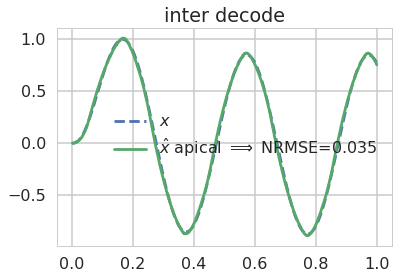

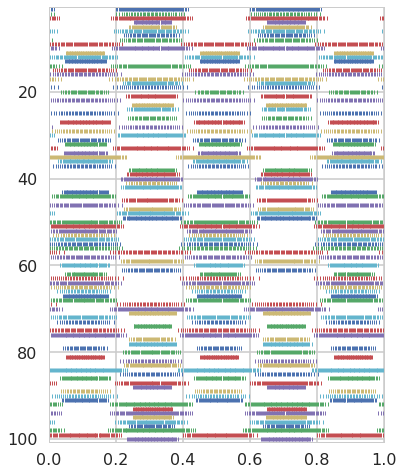

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


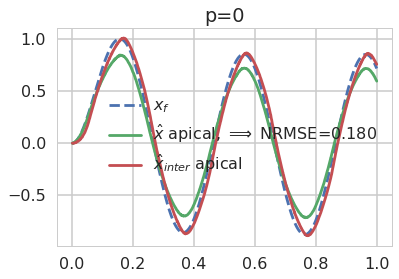

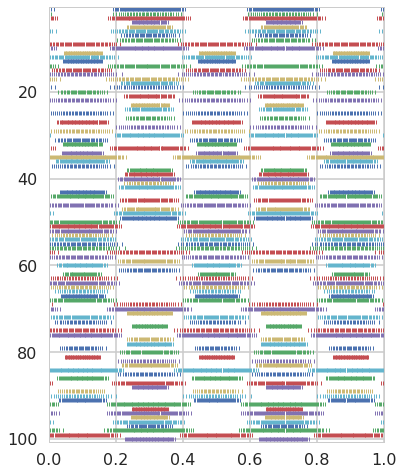

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


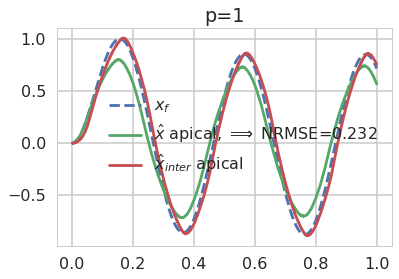

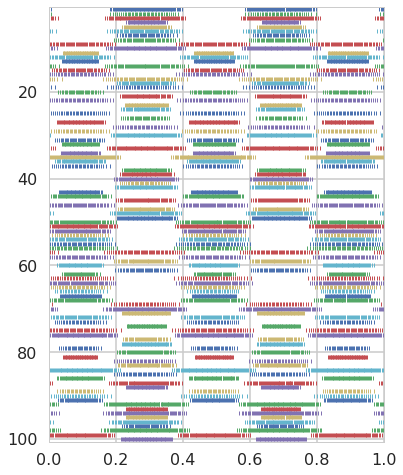

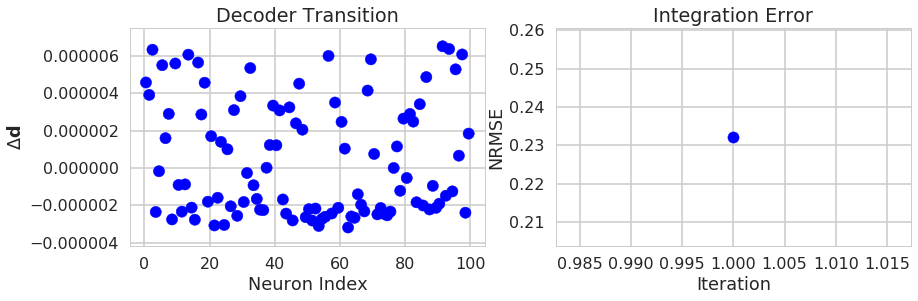

In [8]:
_, _, _ = go2(
    freq=5*np.pi,
    verbose=True,
    solvers=[nengo.solvers.LstsqL2(reg=1.0)],
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    t=1.0)

The label "apical" on the decode incidates that the readout decoder for "bio"'s spikes is identical to the filter used with synapses placed on the default section ("apical") - for the ALIF case, this has no meaning.

Double check that the syntax for multiple connections doesn't break the ALIF case.

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


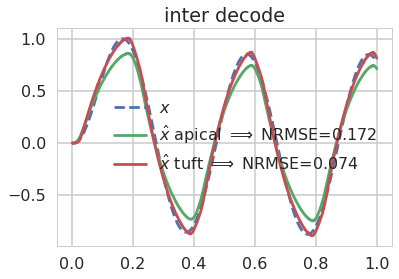

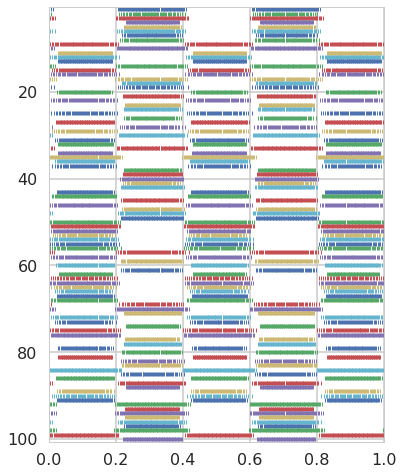

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


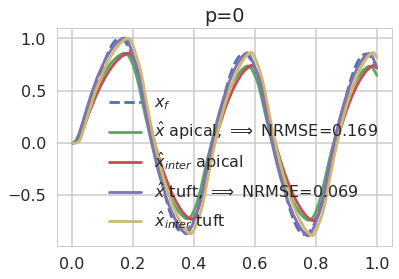

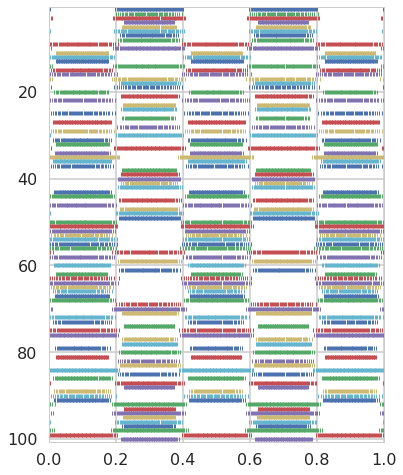

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


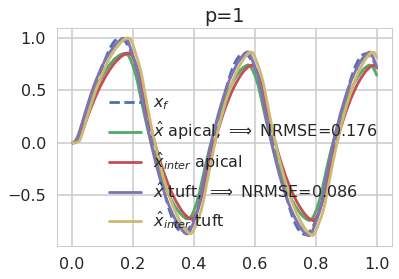

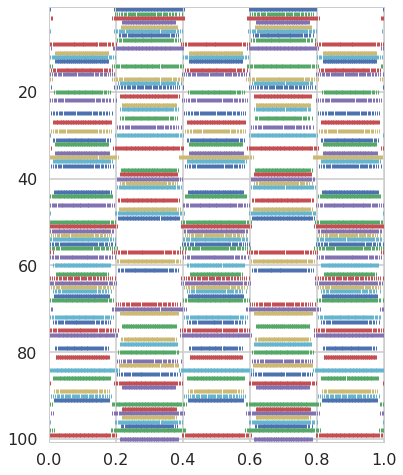

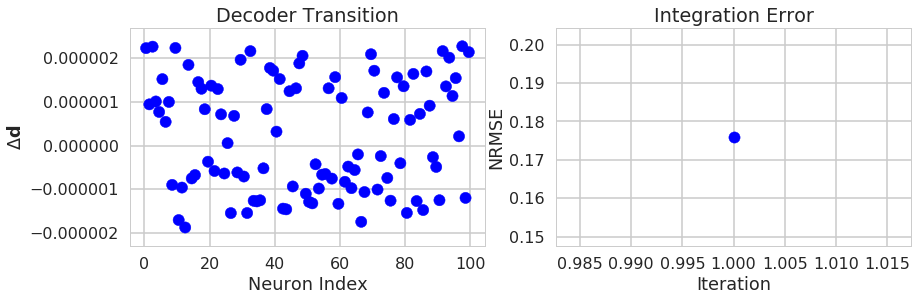

In [9]:
_, _, _ = go2(
    freq=5*np.pi,
    verbose=True,
    inter_solvers=[nengo.solvers.LstsqL2(reg=1.0), nengo.solvers.LstsqL2(reg=0.1)],
    solvers=[nengo.solvers.LstsqL2(reg=1.0), nengo.solvers.LstsqL2(reg=0.1)],
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    t=1.0,
    n_syns=[1, 2],
    secs=['apical', 'tuft'])

Gradual transition with $reg=1.0$ and neuron_type=ALIF()

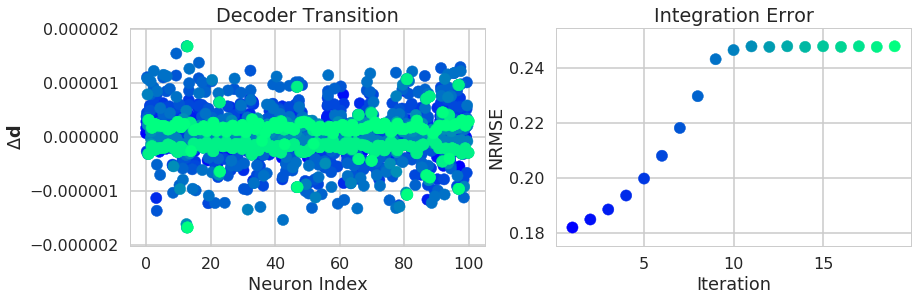

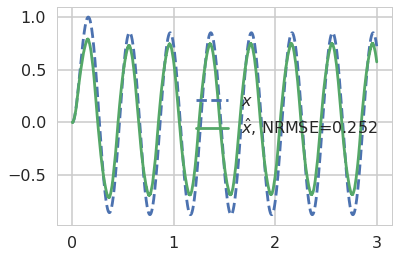

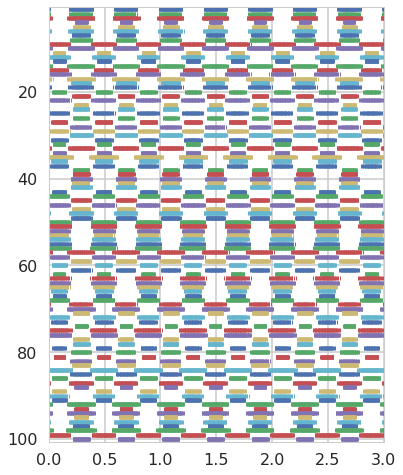

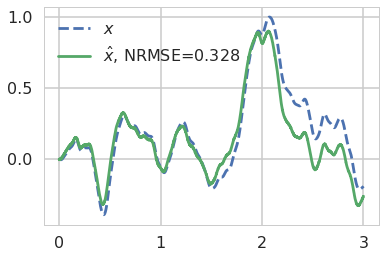

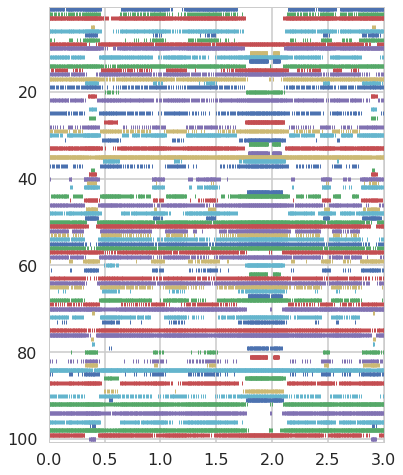

In [10]:
d_inters, d_bios, h_out = go2(
    np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))),
    freq=5*np.pi,
    verbose=False,
    solvers=[nengo.solvers.LstsqL2(reg=1.0)],
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    t=1.0)

test(d_bios,
     signal='cos',
     freq=5*np.pi,
     t=3,
     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
     h_out=h_out,
     verbose=False)

test(d_bios,
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
     h_out=h_out,
     verbose=False)

Observation: slight undershoot of the signal, but good phase-alignment. This is somewhat surprising given we using regular lowpass filters, not those evolved to counteract the phase-shift that occurs in a feedforward network (either with ALIF or bioneurons).

Gradual transition with $reg=0.1$ and neuron_type=ALIF()

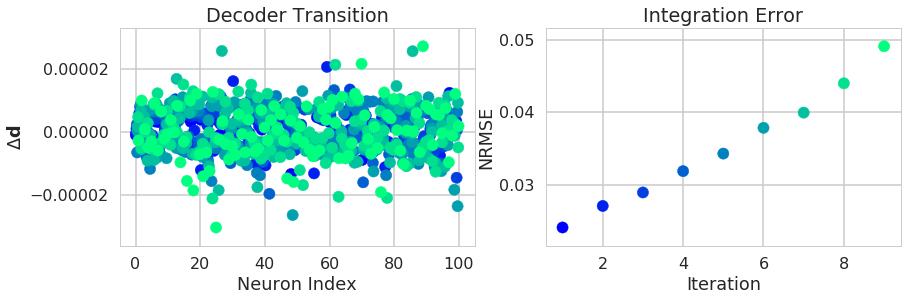

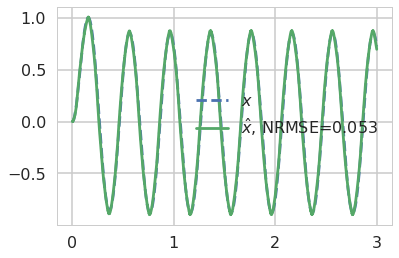

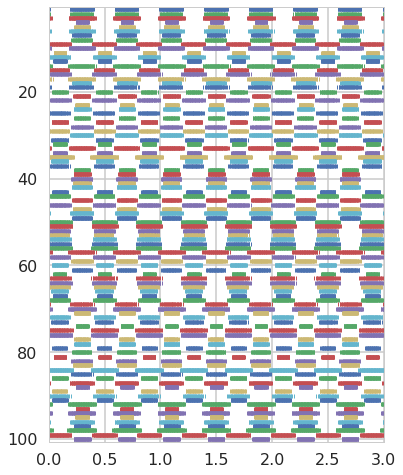

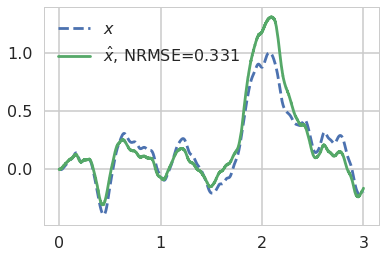

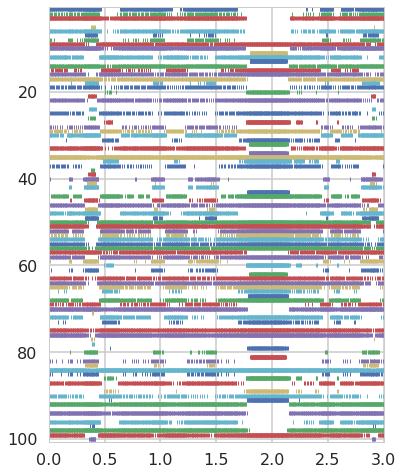

In [11]:
d_inters, d_bios, h_out = go2(
    np.linspace(0, 1, 10),
    freq=5*np.pi,
    verbose=False,
    solvers=[nengo.solvers.LstsqL2(reg=0.1)],
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    t=1.0)

test(d_bios,
     signal='cos',
     freq=5*np.pi,
     t=3,
     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
     h_out=h_out,
     verbose=False)

test(d_bios,
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
     h_out=h_out,
     verbose=False)

tentative conclusion: continuing to apply the training scheme with a small regularization value causes divergence of the decoders (and therefore the estimate), both small and large regularization values perform well on the test set

### Bioneuron testing!
$reg=1.0$, sec='apical'

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:23.                                                 


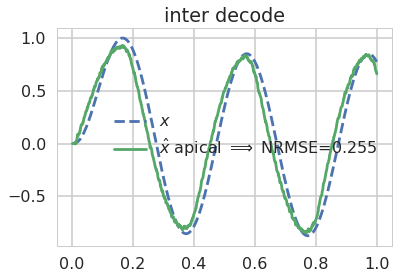

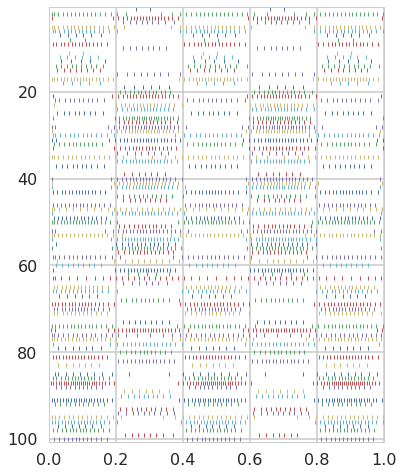

Building finished in 0:00:02.                                                   
Simulating finished in 0:03:33.                                                 


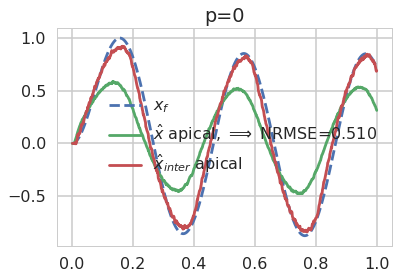

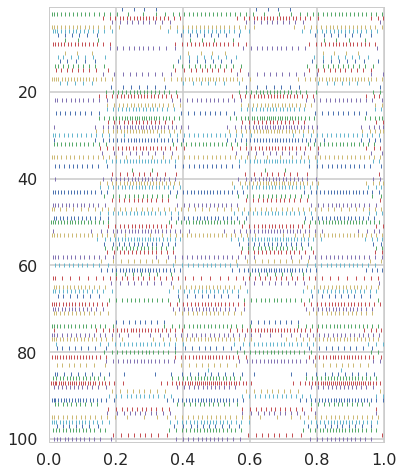

Building finished in 0:00:02.                                                   
Simulating finished in 0:03:32.                                                 


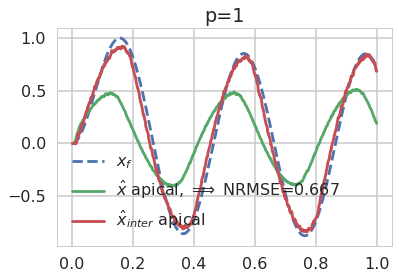

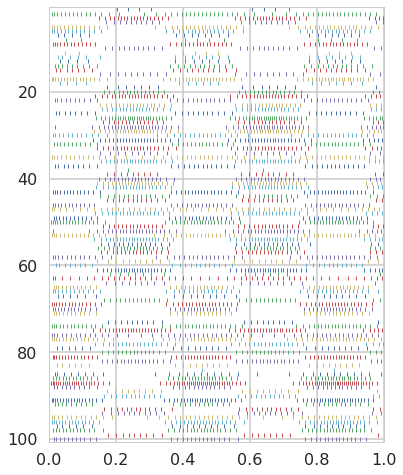

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:04:53.                                                 


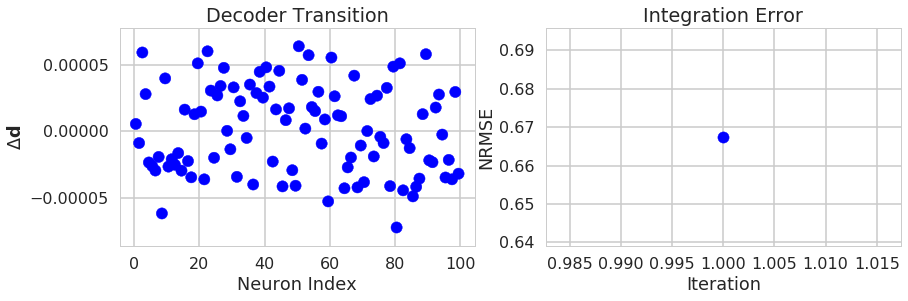

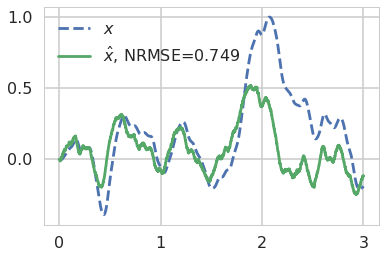

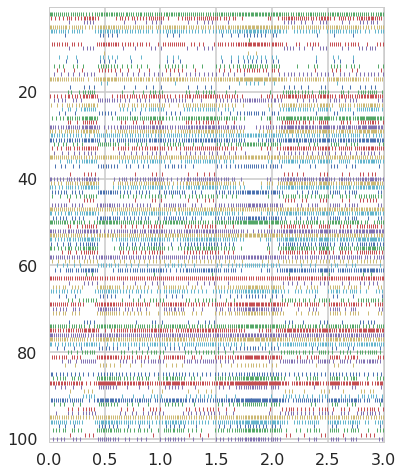

In [12]:
d_inters, d_bios, h_out = go2(
    freq=5*np.pi,
    verbose=True,
    solvers=[nengo.solvers.LstsqL2(reg=1.0)],
    neuron_type=BahlNeuron(),
    t=1.0,
    secs=['apical'])

test(d_bios,
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=BahlNeuron(),
     h_out=h_out,
     verbose=True,
     secs=['apical'])

observation: consistent magnitude undershoot and leftward phase shift of $\hat{x}$ during training, with a unpredictable combination of both when testing with a white_noise signal

$reg=0.1$, sec='apical'

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:23.                                                 


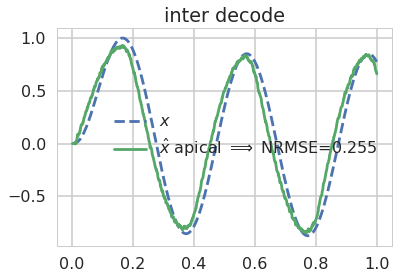

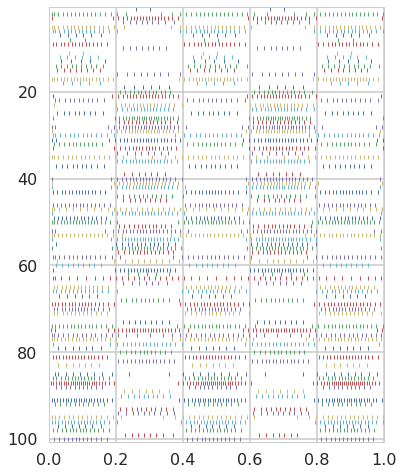

Building finished in 0:00:02.                                                   
Simulating finished in 0:03:45.                                                 


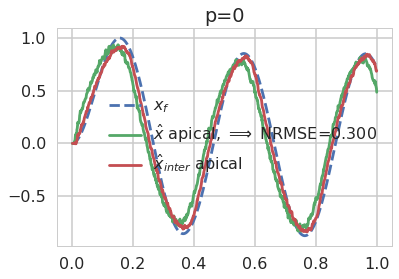

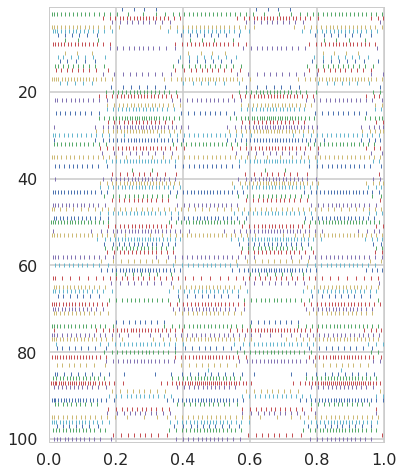

Building finished in 0:00:02.                                                   
Simulating finished in 0:03:45.                                                 


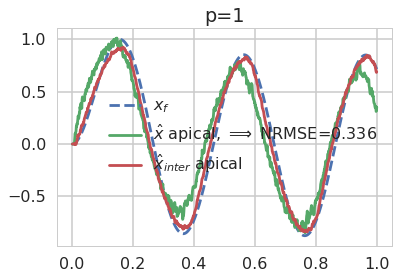

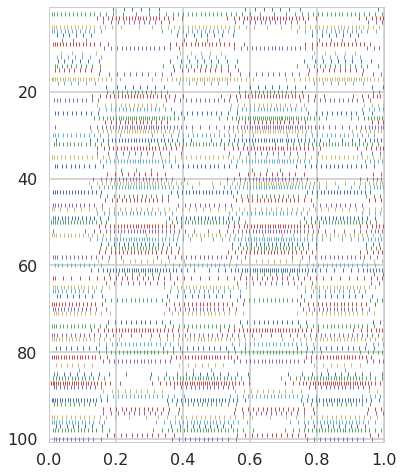

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:05:29.                                                 


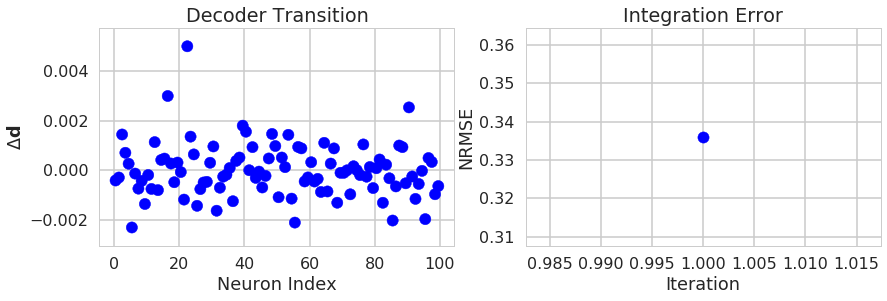

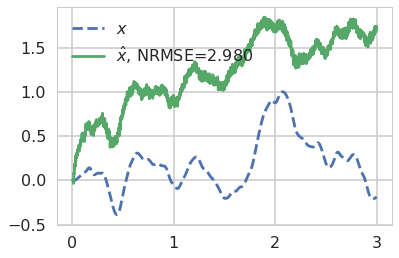

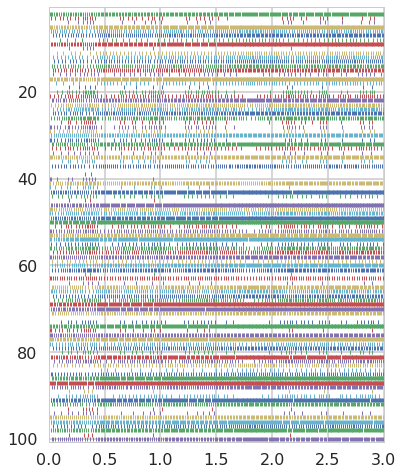

In [13]:
d_inters, d_bios, h_out = go2(n=100,
    freq=5*np.pi,
    verbose=True,
    solvers=[nengo.solvers.LstsqL2(reg=0.1)],
    neuron_type=BahlNeuron(),
    t=1.0,
    secs=['apical'])

test(d_bios,
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=BahlNeuron(),
     h_out=h_out,
     verbose=True,
     secs=['apical'])

observation: only a slight phase shift and undershoot during training, but significant drift when testing on a white_noise signal

hypothesis: with small regularization, the recurrent connection on "bio" is stronger, amplifying noise in certain regions of the phase space where the bioneurons have some kind of "representational gaps". One possible source of these gaps could be supersaturated bioneurons, maybe just two or three, that burst shortly after the simulation starts (usually a cascade of bursting across the network).

One contributing factor is that the synaptic section for this simulation was 'apical', where synapses can drive the bioneurons unrealistically strongly/quickly. I think that the distribution of synapses for most human neurons is on the dendritic tuft, and then a few might be directly onto the soma. It'd be good for me to quantify that for the pyramidal neurons on which Bahl's reduced geometry model is based, maybe even calibrate the synapses off those distributions...

$reg=1.0$, sec='tuft'

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:33.                                                 


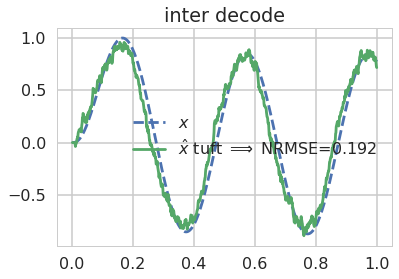

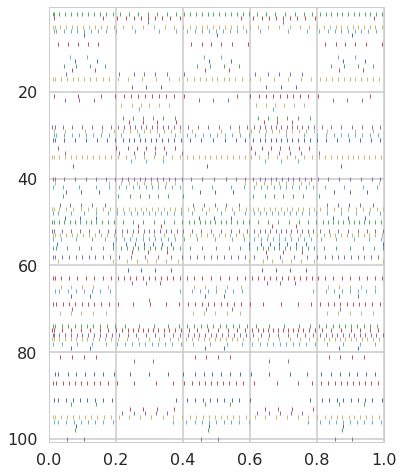

Building finished in 0:00:02.                                                   
Simulating finished in 0:04:11.                                                 


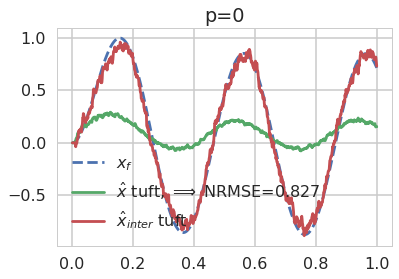

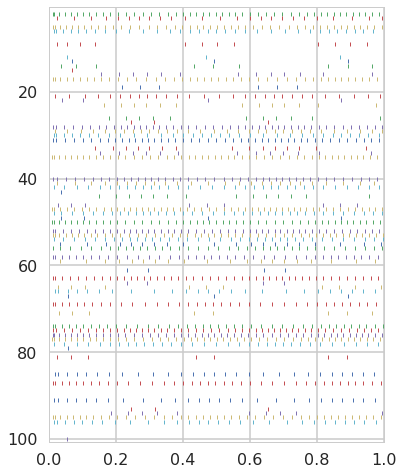

Building finished in 0:00:02.                                                   
Simulating finished in 0:04:08.                                                 


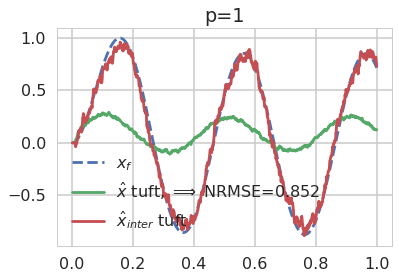

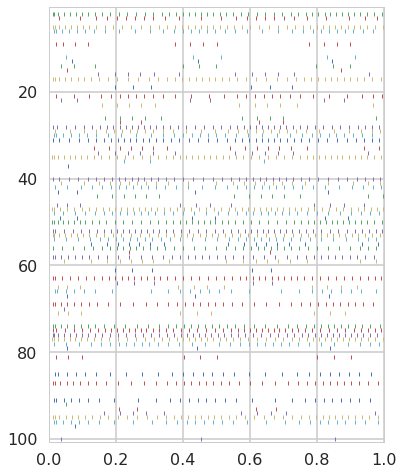

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:05:32.                                                 


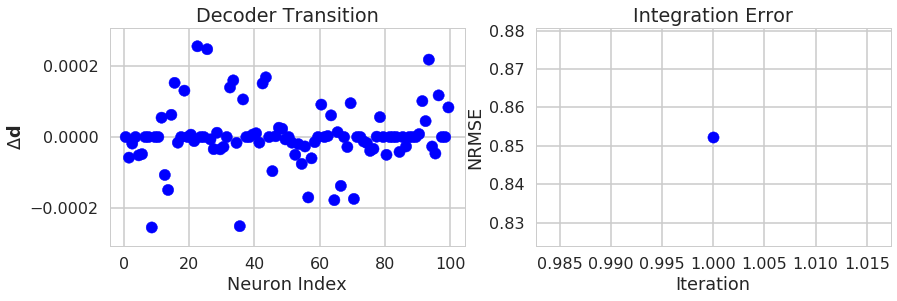

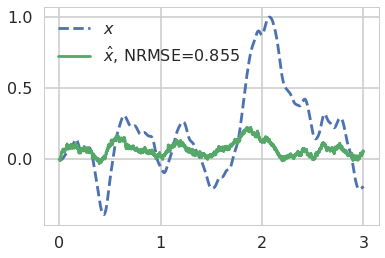

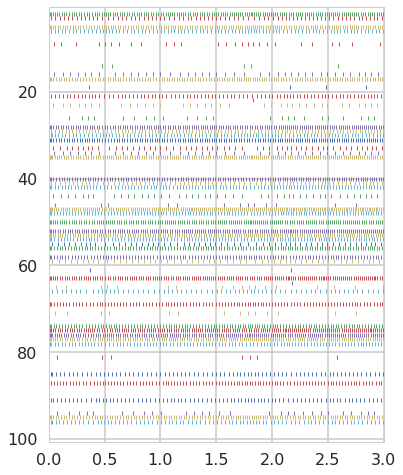

In [14]:
d_inters, d_bios, h_out = go2(
    secs=['tuft'],                        
    freq=5*np.pi,
    verbose=True,
    solvers=[nengo.solvers.LstsqL2(reg=1.0)],
    neuron_type=BahlNeuron(),
    t=1.0)

test(d_bios,
     secs=['tuft'],
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=BahlNeuron(),
     h_out=h_out,
     verbose=True)

observation: there is much less activity from "bio" than from "inter", suggesting that neither the supervision nor the recurrence induces a sufficiently large postsynaptic response, presumably due to attenuation between the tuft and the soma.

## Now what?

If I only connect a few presynaptic neurons onto the apical section, and connect the rest in locations where "fine-tuned" control of the bioneuron's input is possible, I might get enough "force" from the apical connections to make up for insufficient feedback. To do this, I think I'll try creating two connections, make n_syn small for the apical connection while using a large reglarization decoder, and make n_syn large and reg small for the tuft connection.

Start by trying in the ALIF case, reg_apical=1.0, reg_tuft=0.1

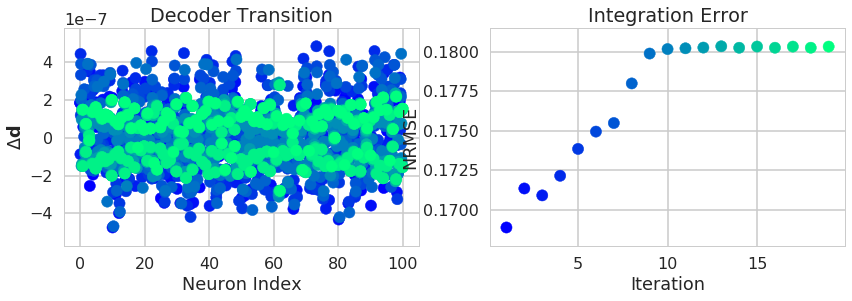

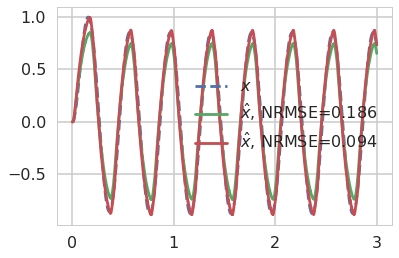

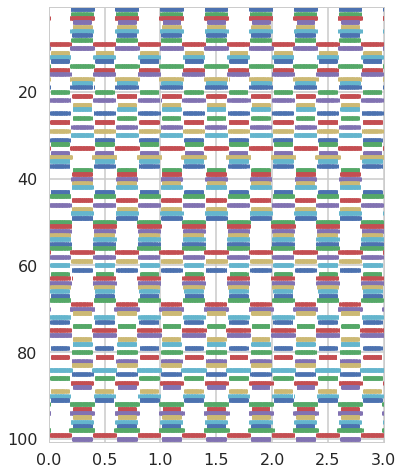

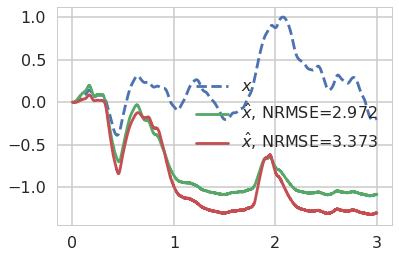

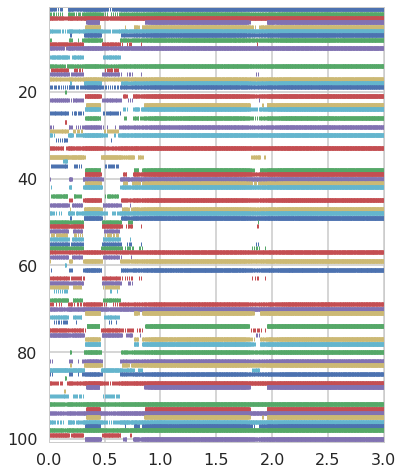

In [15]:
d_inters, d_bios, h_out = go2(
    np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))),
    freq=5*np.pi,
    verbose=False,
    inter_solvers=[nengo.solvers.LstsqL2(reg=1.0), nengo.solvers.LstsqL2(reg=0.1)],
    solvers=[nengo.solvers.LstsqL2(reg=1.0), nengo.solvers.LstsqL2(reg=0.1)],
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    t=1.0,
    n_syns=[1, 5],
    secs=['apical', 'tuft'])

test(d_bios,
     signal='cos',
     freq=5*np.pi,
     t=3,
     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
     h_out=h_out,
     verbose=False,
     n_syns=[1, 5],
     secs=['apical', 'tuft'])

test(d_bios,
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
     h_out=h_out,
     verbose=False,
     n_syns=[1, 5],
     secs=['apical', 'tuft'])

Try much smaller decoder values, since saturation still seems to be a problem. Also, increase n_syn_tuft from 1 to 5

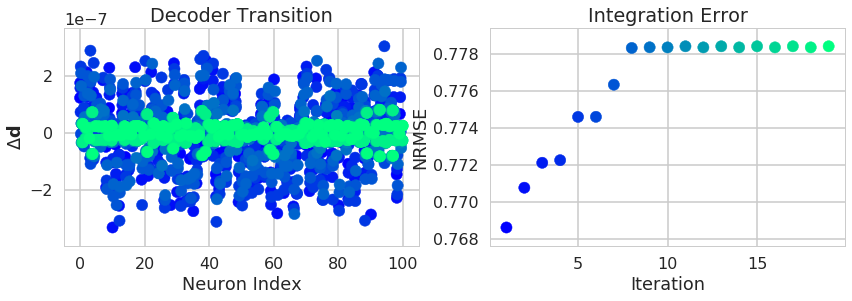

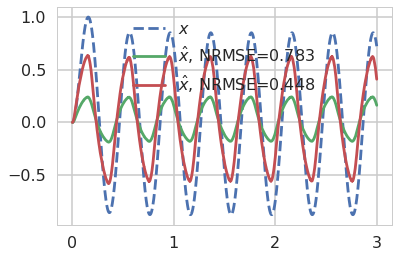

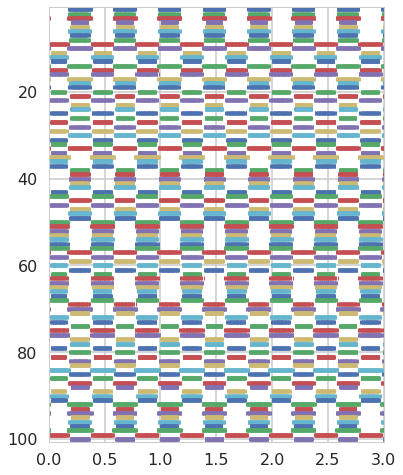

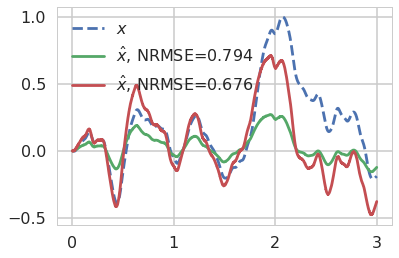

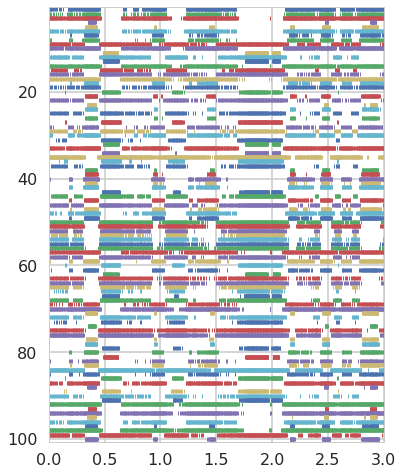

In [16]:
d_inters, d_bios, h_out = go2(
    np.concatenate((np.linspace(0, 1, 10), np.repeat(1, 10))),
    freq=5*np.pi,
    verbose=False,
    inter_solvers=[nengo.solvers.LstsqL2(reg=4.0), nengo.solvers.LstsqL2(reg=1.5)],
    solvers=[nengo.solvers.LstsqL2(reg=4.0), nengo.solvers.LstsqL2(reg=1.5)],
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    t=1.0,
    n_syns=[1, 5],
    secs=['apical', 'tuft'])

test(d_bios,
     signal='cos',
     freq=5*np.pi,
     t=3,
     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
     h_out=h_out,
     verbose=False,
     n_syns=[1, 5],
     secs=['apical', 'tuft'])

test(d_bios,
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
     h_out=h_out,
     verbose=False,
     n_syns=[1, 5],
     secs=['apical', 'tuft'])

## Bioneurons!

Building finished in 0:00:02.                                                   
Simulating finished in 0:03:13.                                                 


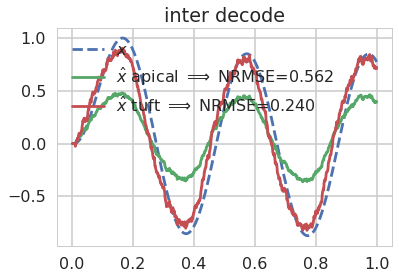

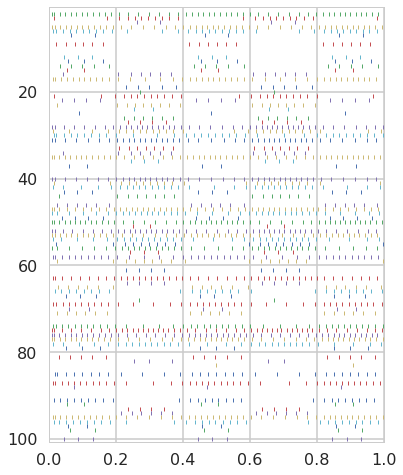

Building finished in 0:00:09.                                                   
Simulating finished in 0:13:34.                                                 


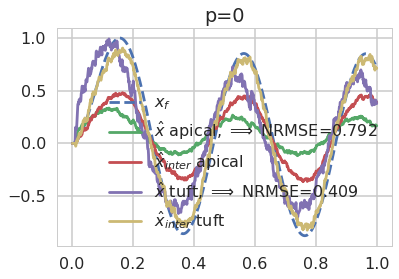

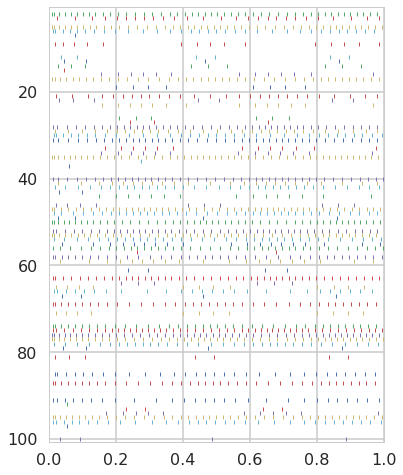

Building finished in 0:00:14.                                                   
Simulating finished in 0:12:44.                                                 


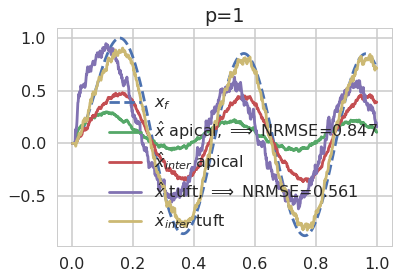

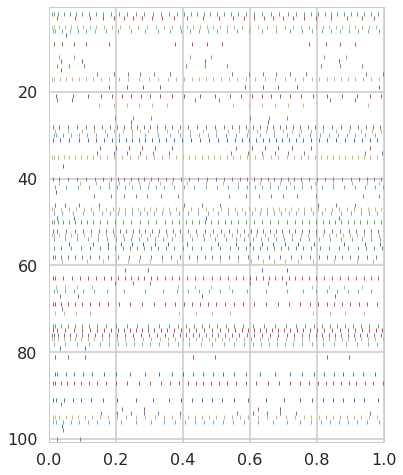

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:03.                                                   
Simulating finished in 0:14:38.                                                 


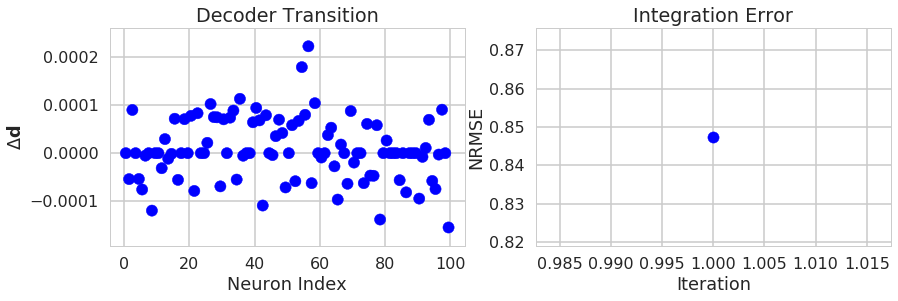

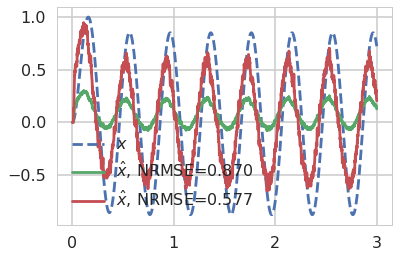

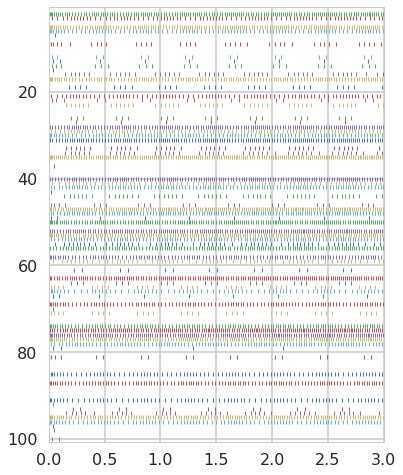

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:03.                                                   
Simulating finished in 0:14:48.                                                 


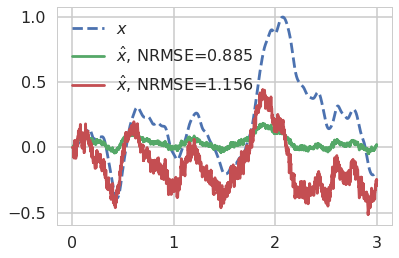

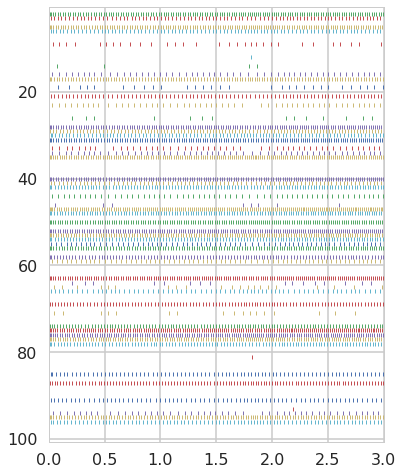

In [17]:
d_inters, d_bios, h_out = go2(
    freq=5*np.pi,
    verbose=True,
    inter_solvers=[nengo.solvers.LstsqL2(reg=1.0), nengo.solvers.LstsqL2(reg=0.2)],
    solvers=[nengo.solvers.LstsqL2(reg=1.0), nengo.solvers.LstsqL2(reg=0.2)],
    neuron_type=BahlNeuron(),
    t=1.0,
    n_syns=[1, 5],
    secs=['apical', 'tuft'])

test(d_bios,
     signal='cos',
     freq=5*np.pi,
     t=3,
     neuron_type=BahlNeuron(),
     h_out=h_out,
     verbose=True,
     n_syns=[1, 5],
     secs=['apical', 'tuft'])

test(d_bios,
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=BahlNeuron(),
     h_out=h_out,
     verbose=True,
     n_syns=[1, 5],
     secs=['apical', 'tuft'])

Building finished in 0:00:02.                                                   
Simulating finished in 0:02:18.                                                 


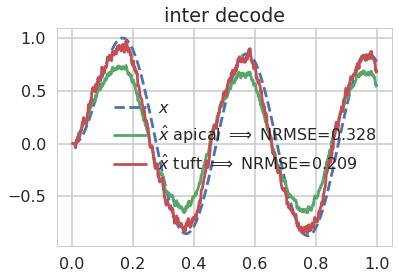

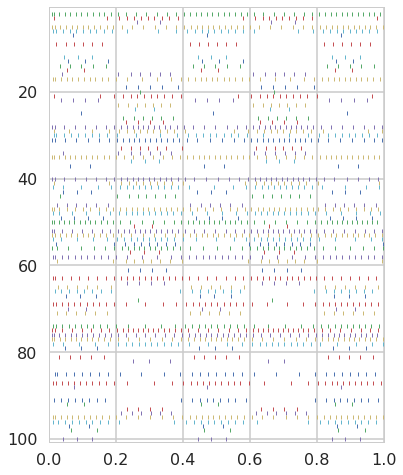

Building finished in 0:00:06.                                                   
Simulating finished in 0:08:06.                                                 


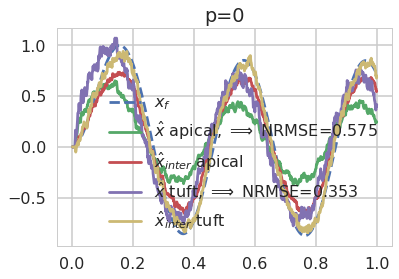

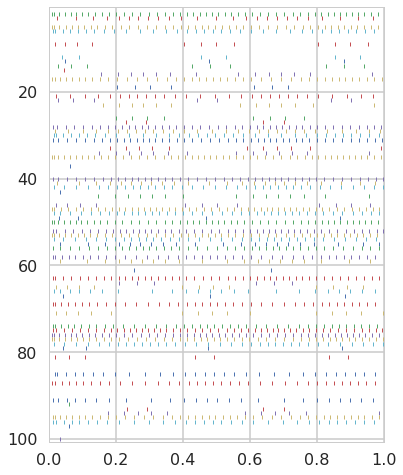

Building finished in 0:00:10.                                                   
Simulating finished in 0:08:50.                                                 


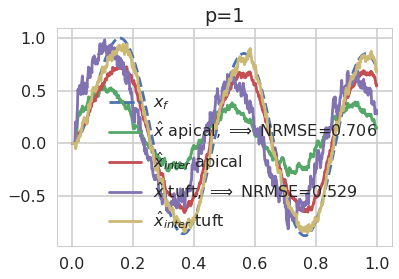

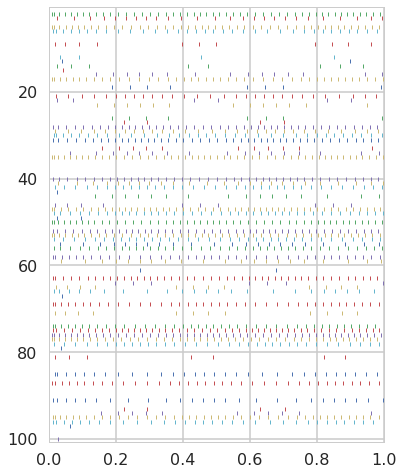

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:10:09.                                                 


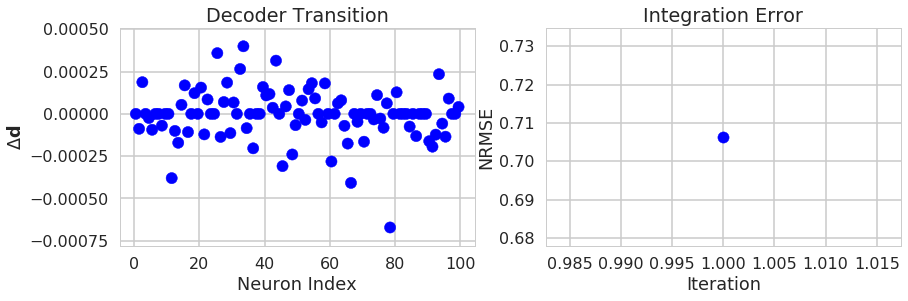

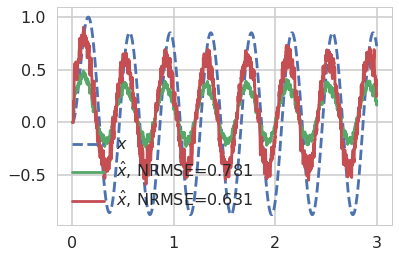

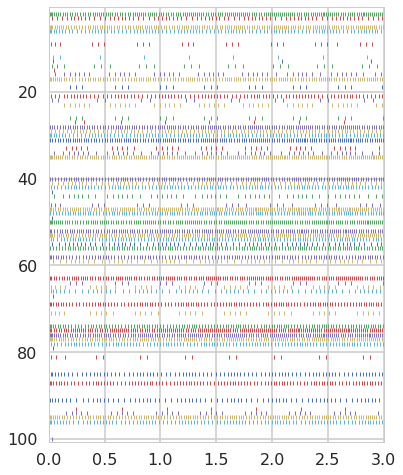

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:10:09.                                                 


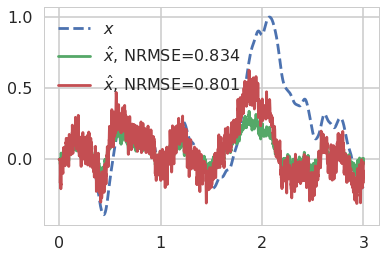

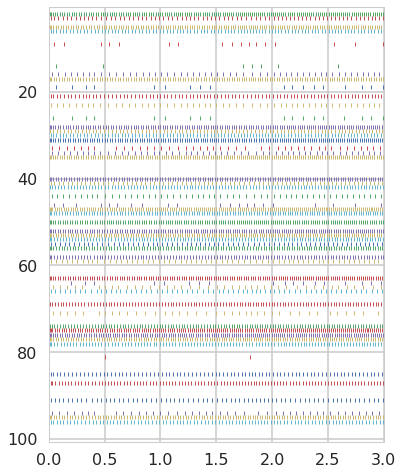

In [18]:
d_inters, d_bios, h_out = go2(
    freq=5*np.pi,
    verbose=True,
    inter_solvers=[nengo.solvers.LstsqL2(reg=0.5), nengo.solvers.LstsqL2(reg=0.1)],
    solvers=[nengo.solvers.LstsqL2(reg=0.5), nengo.solvers.LstsqL2(reg=0.1)],
    neuron_type=BahlNeuron(),
    t=1.0,
    n_syns=[1, 3],
    secs=['apical', 'tuft'])

test(d_bios,
     signal='cos',
     freq=5*np.pi,
     t=3,
     neuron_type=BahlNeuron(),
     h_out=h_out,
     verbose=True,
     n_syns=[1, 3],
     secs=['apical', 'tuft'])

test(d_bios,
     signal='white_noise',
     freq=5*np.pi,
     t=3,
     neuron_type=BahlNeuron(),
     h_out=h_out,
     verbose=True,
     n_syns=[1, 3],
     secs=['apical', 'tuft'])

Not much improvement over just 'apical'